In [1]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
import fortpy as fp

sns.set(style='darkgrid')
x = tqdm.tqdm_notebook()
x.close()

/home/gatlin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


0it [00:00, ?it/s]

In [2]:
class Output(object):
    def __init__(self, masses=[], positions=[], velocities=[], times=[],
                 coms=[], avvs=[], energies=[], amomentums=[],
                 eccentricities=[], count=0, n_bodies=0):
        self.masses = masses
        self.positions = positions
        self.velocities = velocities
        self.times = times
        self.coms = coms
        self.avvs = avvs
        self.energies = energies
        self.amomentums = amomentums
        self.eccentricities = eccentricities
        self.count = count
        self.n_bodies = n_bodies
        self.model_out = [self.masses, self.positions, self.velocities,
                          self.times, self.coms, self.avvs, self.n_bodies]

    def calculate_auxilary_values(self, com=None, avv=None):
        """Computes the energy and angular momentum of a system of particles.
        The energy is computed as the kinetic energy of a particle minus the
        potential energy of every other particle relative to it. The angular
        momentum is the cross product of positions and velocities, relative to 
        the center of mass.
        """
        if com is None:
            com = self.coms
        if avv is None:
            avv = self.avvs
        nrg_rel = np.zeros(self.positions.shape[0])
        h_rel = np.zeros((self.positions.shape[0],) + (3,))

        for i in range(self.positions.shape[1]):
            # if masses[i] != 0:
            nrg_rel += 0.5 * np.linalg.norm(self.velocities[:, i, :]
                                            - avv, axis=1)**2
            for j in range(i+1, self.positions.shape[1]):
                # if masses[i] != 0:
                nrg_rel -= self.masses[i] / np.linalg.norm(
                    self.positions[:, i, :] - self.positions[:, j, :], axis=1
                    )
            h_rel += np.cross(self.positions[:, i, :] - com,
                              self.velocities[:, i, :] - avv)
        e_rel = np.sqrt(1 + 2 * nrg_rel * np.linalg.norm(h_rel, axis=1)
                        / np.sum(self.masses)**2)
        self.eccentricities = e_rel
        self.energies = nrg_rel
        self.amomentums = h_rel


def calc_com(masses, pos):
    """A simple function that compute the center of mass of a system
    """
    return (masses[:, None] * pos).sum(axis=0) / masses.sum()
    # return ((masses*pos.T).T).sum(axis = 0) / masses.sum()


def calc_avv(masses, vel):
    """A simple function that computes the average velocity of a system
    """
    return (masses[:, None] * vel).sum(axis=0) / masses.sum()
    # return ((masses*vel.T).T).sum(axis = 0) / masses.sum()


def adjust_timestep(dt, err, q, t_tot):
#     facmax = 6.
#     facmin = 0.33
    fac = 0.38**(1. / (1. + q))
    dt_new = dt * fac * err**(-1. / (1. + q))
#     if (dt_new > facmax * dt):
#         dt_new = facmax * dt
#     elif (dt_new < facmin * dt):
#         dt_new = facmin * dt
    if (dt_new / t_tot < 1e-12) or np.isnan(dt_new):
        dt_new = t_tot * 1e-12
    return dt_new


def adaptive_n_body(integrator, masses, i_positions, i_velocities,
                    t_tot, tolerance, dt_0=1e-2, q=2, update_com=True,
                    **kwargs):
    """
    An n-body time integrator, that simulates the positions and velocities of
    an ensemble of particles in a gravity field.
    Inputs:
    integrator: A function that computes new positions and velocities, which
     takes masses, positions, velocities, and a timestep as inputs, and returns
     a pair of positions and velocities, the first two are the lower-order
     positions and velocities, the second pair is the higher-order check of the
     positions and velocities
    masses: A 1-D array of particle masses
    i_positions: A 2-D array of shape particles*dimensions of particle initial
    positions
    i_velocities: A 2-D array of shape particles*dimensions of particle initial
    velocities
    t_tot: A float of the total time of integration
    dt: The timestep
    
    Note: The integration is done using jacobi coordinates (ie relative to a 
     center of mass reference frame. If your inputs are not given in a center
     of mass reference frame, your inputs may not look like the initial state of
     the outputs)

    Outputs:
    positions, velocities, times, center of masses, average velocities, all
     as arrays. Positions and velocities are 3-D arrays of shape
     times*particles*dimensions. Times is a 1-D array of shape times. Center
     of mass and average velocities are of shape times*dimensions and only
     represent the change of the center of mass and velocity in the previous
     time step

    """
    # All the information we need to compute the times is given at the start
    times = []
    positions = []
    velocities = []
    coms = []
    avvs = []
    errors = []
    # compute the center of mass and average velocities and update the inputs
    # before they are added to our data
    com = calc_com(masses, i_positions)
    avv = calc_avv(masses, i_velocities)
    if update_com:
        pos2 = i_positions - com
        vel2 = i_velocities - avv
    else:
        pos2 = i_positions
        vel2 = i_velocities
    t = 0.
    dt = dt_0
    err = 0.
    count = 0
    pbar = tqdm.notebook.tqdm(total=t_tot,bar_format='{desc}: {percentage:3.0f}'
    '% {n:.3f}/{total:.3f} [{elapsed}<{remaining}, {rate_fmt}{postfix}]')
    n_recalculates = 0
    while ((t < t_tot) and (count < 1000000)):
        pbar.update(dt)
        times.append(t)
        positions.append(pos2)
        velocities.append(vel2)
        coms.append(com)
        avvs.append(avv)
        errors.append(err)
#         second_count = 0
#         while second_count < 100:
        pos1, vel1, pos2, vel2 = integrator(masses, pos2, vel2, dt,
                                                **kwargs)
            # To handle most critical bugs in any integrator function, this will
            # raise an error if the outputs are nonsense
        if np.any(np.isnan(pos2)):
            raise ValueError('nan encountered')
        com = calc_com(masses, pos2)
        avv = calc_avv(masses, vel2)
        if update_com:
            pos2 -= com
            vel2 -= avv
        
        # Adjust timestep
        err = np.concatenate((pos1 - pos2, vel1 - vel2))
        err = np.linalg.norm(err / tolerance) / np.sqrt(err.size)
    
        dt = adjust_timestep(dt, err, q, t_tot)
        # if err <= 1:  # Happens when the solution is accurate enough
        #     break
        # 
        # second_count += 1
        # if second_count > 10:
        #     print('Recalculated for more than 10 loops')
        # n_recalculates += second_count
        t += dt

        count += 1
    pbar.close()
    times = np.array(times)
    positions = np.array(positions)
    velocities = np.array(velocities)
    coms = np.array(coms)
    avvs = np.array(avvs)
    errors = np.array(errors)
    out = Output(masses=masses, positions=positions, velocities=velocities,
                 times=times, coms=coms, avvs=avvs,
                 count=count, n_bodies=len(masses))
    out.errors = errors
    return out

def n_body(integrator, masses, i_positions, i_velocities, t_tot, dt,
           update_com=True, **kwargs):
    """
    An n-body time integrator, that simulates the positions and velocities of
    an ensemble of particles in a gravity field.
    Inputs:
    integrator: A function that computes new positions and velocities, which
     takes masses, positions, velocities, and a timestep as inputs
    masses: A 1-D array of particle masses
    i_positions: A 2-D array of shape particles*dimensions of particle initial
    positions
    i_velocities: A 2-D array of shape particles*dimensions of particle initial
    velocities
    t_tot: A float of the total time of integration
    dt: The timestep
    
    Note: The integration is done using jacobi coordinates (ie relative to a 
     center of mass reference frame. If your inputs are not given in a center
     of mass reference frame, your inputs may not look like the initial state of
     the outputs)

    Outputs:
    positions, velocities, times, center of masses, average velocities, all
     as arrays. Positions and velocities are 3-D arrays of shape
     times*particles*dimensions. Times is a 1-D array of shape times. Center
     of mass and average velocities are of shape times*dimensions and only
     represent the change of the center of mass and velocity in the previous
     time step

    """
    # All the information we need to compute the times is given at the start
    n_steps = int(t_tot / dt)
    times = np.linspace(0., t_tot, n_steps + 1)
    positions = []
    velocities = []
    coms = []
    avvs = []
    # compute the center of mass and average velocities and update the inputs
    # before they are added to our data
    com = calc_com(masses, i_positions)
    avv = calc_avv(masses, i_velocities)
    if update_com:
        pos = i_positions - com
        vel = i_velocities - avv
    else:
        pos = i_positions
        vel = i_velocities
    for i, time in tqdm.tqdm(list(enumerate(times))):
        positions.append(pos)
        velocities.append(vel)
        coms.append(com)
        avvs.append(avv)
        out = integrator(masses, pos, vel, dt, **kwargs)
        if len(out) == 2:
            pos, vel = out
        elif len(out) == 4:
            pos, vel = out[:2]
            # In case you're using an adaptive integrator in 
            #n_body, this will allow it to run (good for testing)
        # To handle most critical bugs in any integrator function, this will
        # raise an error if the outputs are nonsense
        if np.any(np.isnan(pos)):
            raise ValueError('nan encountered')
        com = calc_com(masses, pos)
        avv = calc_avv(masses, vel)
        if update_com:
            pos -= com
            vel -= avv
    positions = np.array(positions)
    velocities = np.array(velocities)
    coms = np.array(coms)
    avvs = np.array(avvs)
    return Output(masses, positions, velocities, times, coms, avvs,
                  count=n_steps + 1, n_bodies=len(masses))

In [3]:
def kick_drift_kick(masses, positions, velocities, dt, G=1):
    """A kick-drift-kick integrating scheme. Each time step really involves
     two gravity calculations, so this is approximately twice as intensive
     as an euler integration scheme, although it is accurate to dt**4
    """
    accels = np.zeros(positions.shape)
    vels = np.zeros(positions.shape)
    poses = np.zeros(positions.shape)
    for i, pos in enumerate(positions):
        for j, pos2 in enumerate(positions):
            if i != j: 
                if masses[j] != 0:

                    r = pos2 - pos
                    accels[i] += G * masses[j] / np.linalg.norm(r)**3 * r
        vels[i] = velocities[i] + accels[i] * dt / 2 #kick
        poses[i] = pos + vels[i] * dt #drift

    # Need to re-zero the accelerations before the final kick
    accels = np.zeros(positions.shape) 
    for i, pos in enumerate(poses): # Now we are looping through the poses
    # array instead of positions as positions was the initial positions
        for j, pos2 in enumerate(poses):
            if i != j:
                if masses[j] != 0:
                    r = pos2 - pos
                    accels[i] += masses[j] / np.linalg.norm(r)**3 * r
        vels[i] = vels[i] + accels[i] * dt / 2 #kick
    return poses, vels


def kick_drift_kick_galaxy(masses, positions, velocities, dt, G=1):
    """A kick-drift-kick integrating scheme. Each time step really involves
     two gravity calculations, so this is approximately twice as intensive
     as an euler integration scheme, although it is accurate to dt**4
    """
    assert (positions.shape == velocities.shape)\
     and (positions.shape[0] == masses.shape[0]), ("Shapes must match: {} {}"
      " {}".format(
         positions.shape, velocities.shape, masses.shape))
     
    accels = np.zeros(positions.shape)
    vels = velocities.copy()
    poses = np.zeros(positions.shape)
    for i, pos in enumerate(positions):
        r = np.linalg.norm(pos)
#         print(pos)
        accels[i] = (-np.log(1+r) / r**2 + 1 / r / (1+r)) * (pos/r)
#         print(accels[i])
        vels[i] += accels[i] * dt / 2 #kick
#         print(vels[i])
        poses[i] = pos + vels[i] * dt #drift
        # print(accels[i], vels[i])

    # Need to re-zero the accelerations before the final kick
    accels = np.zeros(positions.shape) 
    for i, pos in enumerate(poses):
        r = np.linalg.norm(pos)
        accels[i] = (-np.log(1+r) / r**2 + 1 / r / (1+r)) * (pos/r)    
        vels[i] += accels[i] * dt / 2 #kick
        # print(accels[i], vels[i])
    return poses, vels


def rk_pde(masses, positions, velocities, G=1):
    """Returns velocities and accelerations of a body at a given
    position. Used inside the Runge-Kutta Methods
    """
    assert (positions.shape == velocities.shape)\
     and (positions.shape[0] == masses.shape[0]), ("Shapes must match: {} {}"
      " {}".format(
         positions.shape, velocities.shape, masses.shape))
    
    k_vels = np.zeros(positions.shape)
    k_poses = velocities.copy()

    for i, pos in enumerate(positions):
        r = np.linalg.norm(pos)
        k_vels[i] = -np.log(1+r) / r**2 + 1 / r / (1+r)
        
    return k_poses, k_vels


def rkf45(masses, positions, velocities, dt, **kwargs):
    k_poses = np.zeros((6,) + positions.shape)
    k_vels = np.zeros((6,) + positions.shape)
    coefficients = np.array([[1. / 4., 0., 0., 0,  0.],
                            [3. / 32., 9. / 32., 0., 0., 0.],
                            [1932. / 2197., -7200. / 2197., 7296. / 2197., 0.,
                             0.],
                            [439. / 216., -8, 3680. / 513., -845. / 4104., 0.],
                            [-8. / 27., 2., -3544. / 2565., 1859. / 4104.,
                             -11. / 40.]])
    weights_4 = np.array([25. / 216, 0., 1408. / 2565., 2197. / 4104., -0.2,
                          0.])
    weights_5 = np.array([16. / 135., 0.,6656. /12825., 28561. / 56430.,
                          -9. / 50., 2. / 55.]) 
    k_poses[0], k_vels[0] = rk_pde(masses, positions, velocities, **kwargs)
    for i, coeffs in enumerate(coefficients):
        k_poses[i + 1], k_vels[i + 1] = rk_pde(masses,
            positions + (k_poses[:-1] * coefficients[i][:, None, None] * dt
                         ).sum(axis=0),
            velocities + (k_vels[:-1] * coefficients[i][:, None, None] * dt
                          ).sum(axis=0), **kwargs)
    poses_4 = positions + (dt * weights_4[:, None, None] * k_poses).sum(axis=0)
    vels_4 = velocities + (dt * weights_4[:, None, None] * k_vels).sum(axis=0)
    poses_5 = positions + (dt * weights_5[:, None, None] * k_poses).sum(axis=0)
    vels_5 = velocities + (dt * weights_5[:, None, None] * k_vels).sum(axis=0)
    return poses_4, vels_4, poses_5, vels_5

In [22]:
r = 1.
grav = - np.log(1 + r)/r**2 + 1/(r * (1 + r))
masses = np.array([0., 0.])  # , 0.])
eccentricities = np.array([0., 0.5])
                           # , 0.5, 0.75])
i_positions = np.array([[1., 0., 0.],
                        # [1., 0., 0.],
                        [1., 0., 0.]])
i_velocities = np.array([[0., 1., 0.],
                        #  [0., 1., 0.],
                         [0., 1., 0.]
                            ]) * (np.sqrt(-grav*r)
                                           * np.sqrt((1 - eccentricities)
                           / (1 + eccentricities))[:, None])

dt = 1e-3
galaxy = n_body(fp.integrators.kdk_gal, masses, i_positions, i_velocities, 100,
                dt, update_com=False)
galaxy.calculate_auxilary_values()


/home/gatlin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
/home/gatlin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 100001/100001 [00:08<00:00, 11679.03it/s]
/home/gatlin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Spatial plot of Star in Dark Matter Halo $dt=10^{-3}$')

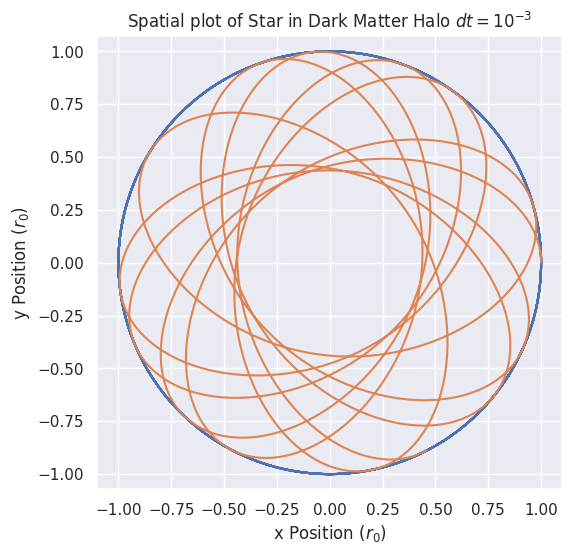

In [23]:
fig = plt.figure(figsize=(6, 6), dpi=100)
ax = fig.gca()
ax.plot(galaxy.positions[:, :, 0], galaxy.positions[:, :, 1])

ax.axis('equal')
ax.set_xlabel(r'x Position ($r_0$)')
ax.set_ylabel(r'y Position ($r_0$)')
ax.set_title(r"Spatial plot of Star in Dark Matter Halo $dt=10^{-3}$")
# ax.set_xlim(-1., 1.)
# ax.set_ylim(-1, 1)
# ax.legend()

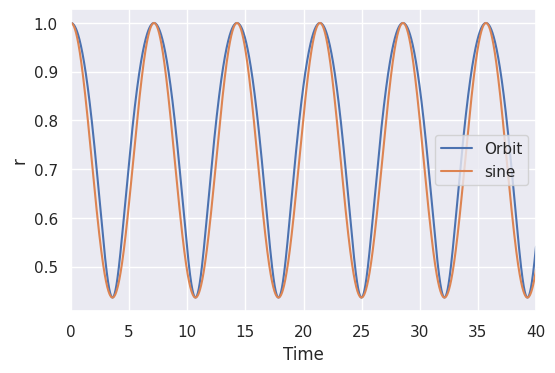

In [24]:
r = np.linalg.norm(galaxy.positions[:, 1, :], axis=1)
T = galaxy.times[r == r[(galaxy.times > 5) & (galaxy.times < 10)].max()]
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
ax.plot(galaxy.times, r, label='Orbit')
ax.plot(galaxy.times, (np.cos(galaxy.times* 2 * np.pi/T) + 1) * (r.max() - r.min()) / 2 + r.min(),label='sine')
# ax.set_yscale('log')
ax.set_xlabel('Time')
ax.set_ylabel('r')
ax.set_xlim(0, 40)
ax.legend()

Text(0, 0.5, '$\\phi$')

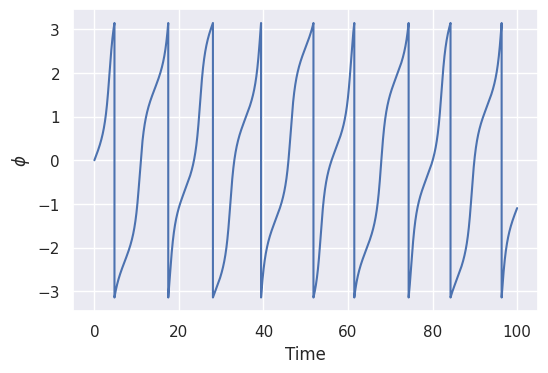

In [7]:
phi = np.arctan2(galaxy.positions[:, 1, 1], galaxy.positions[:, 1, 0])

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
ax.plot(galaxy.times, phi)
ax.set_xlabel('Time')
ax.set_ylabel(r'$\phi$')
# ax.set_ylim(-1, 1)

Text(0, 0.5, '$|\\Delta E/E_0|$')

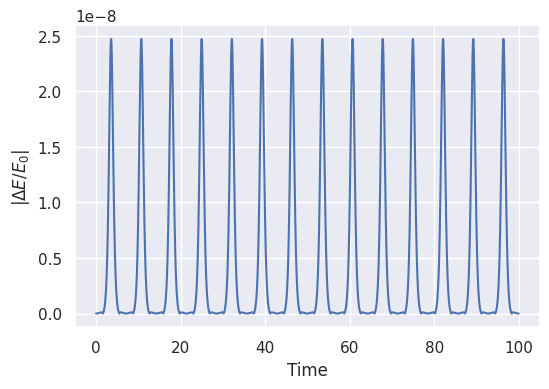

In [12]:
# sma = (1 / (2 / np.linalg.norm(galaxy.positions[:,1,:], axis=1)
r = np.linalg.norm(galaxy.positions[:,1,:], axis=1)
nrg = 0.5 * np.linalg.norm(galaxy.velocities[:,1,:], axis=1)**2
nrg -= (np.log(1 + r) / r)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
ax.plot(galaxy.times, np.abs((nrg - nrg[0]) / nrg[0]))
# ax.plot(galaxy.times, nrg, label='Kinetic Energy')
# ax.plot(galaxy.times, nrg - nrg2, label='Total')
# ax.set_yscale('log')
ax.set_xlabel('Time')
ax.set_ylabel(r'$|\Delta E/E_0|$')
# ax.legend(

Text(0, 0.5, '$|\\Delta h/h|$')

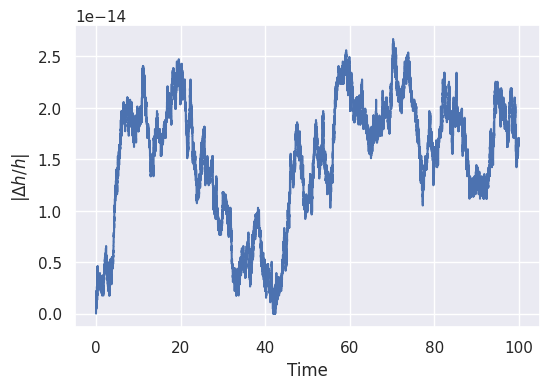

In [16]:
h = np.cross(galaxy.positions, galaxy.velocities, axis=2)[:, 1]
h_mag = np.linalg.norm(h, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
ax.plot(galaxy.times, np.abs((h_mag - h_mag[0]) / h_mag))
# ax.set_yscale('log')
ax.set_xlabel('Time')
ax.set_ylabel(r'$|\Delta h/h|$')

Text(0, 0.5, 'a')

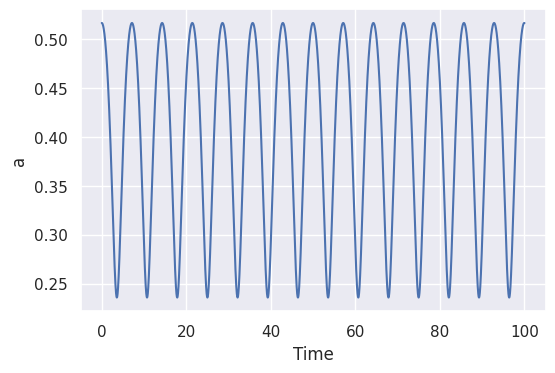

In [17]:
sma = (1 / (2 / np.linalg.norm(galaxy.positions[:,1,:], axis=1)
       - np.linalg.norm(galaxy.velocities[:,1,:], axis=1)**2 / 1))

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
ax.plot(galaxy.times, sma)
# ax.set_yscale('log')
ax.set_xlabel('Time')
ax.set_ylabel(r'a')

Radial Period: 

$$T_r = 2 \int_{r_{min}}^{r_{max}} \frac{dr}{\sqrt{2(E-\phi) - L^2/R^2}}$$

Precession Rate:

$$\Delta \phi = 2L \int_{r_{min}}^{r_{max}} \frac{dr}{\sqrt{2(E-\phi) - L^2/R^2}}$$



## Globular Cluster

In [19]:
num_points = 100
phi = np.random.random(num_points) * 2*np.pi
theta = np.arccos(2*np.random.random(num_points)-1)
r = np.cbrt(np.random.random(num_points))

# from Wlad:
#r = np.cbrt(random.rand())
#costh = 2*random.rand()-1
#theta = np.arccos(costh)

grav = - np.log(1 + r)/r**2 + 1/(r * (1 + r))
# grav = - 1 / r**2

glob_masses = np.ones(num_points)

glob_i_pos = np.zeros((num_points,3))
glob_i_pos[:,0] = r*np.sin(theta)*np.cos(phi)
glob_i_pos[:,1] = r*np.sin(theta)*np.sin(phi)
glob_i_pos[:,2] = r*np.cos(theta)
free_fall_time = 1 / 4 * np.sqrt(3 * np.pi / 2 / 100) 

eccentricities = 0

glob_i_vel_radial = (np.sqrt(-grav*r) * np.sqrt((1 - eccentricities)
                     / (1 + eccentricities)))
glob_i_vel = np.zeros((num_points, 3))
glob_i_vel[:, 0] = glob_i_vel_radial * np.sin(theta) * np.cos(phi)
glob_i_vel[:, 1] = glob_i_vel_radial * np.sin(theta) * np.sin(phi)
glob_i_vel[:, 2] = glob_i_vel_radial * np.cos(theta)
globular = n_body(fp.integrators.kdk_gal, glob_masses, glob_i_pos, glob_i_vel,
                  100, 1e-3)

100%|██████████| 100001/100001 [00:11<00:00, 9035.43it/s]


Text(0.5, 1.0, 'Spatial plot of Star in Dark Matter Halo $dt=10^{-3}$')

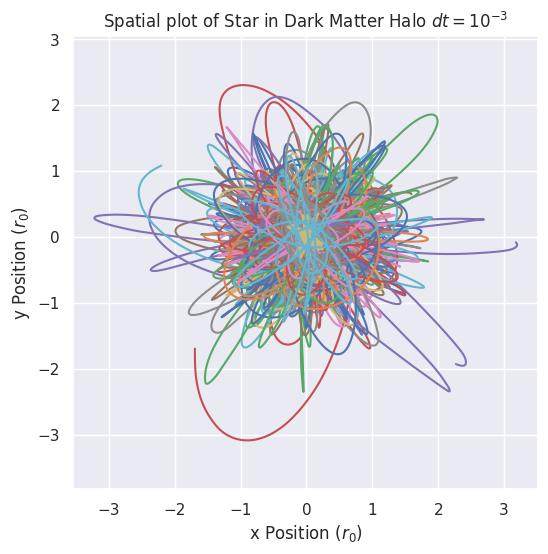

In [20]:
fig = plt.figure(figsize=(6, 6), dpi=100)
ax = fig.gca()
ax.plot(globular.positions[:, :, 0], globular.positions[:, :, 1])

ax.axis('equal')
ax.set_xlabel(r'x Position ($r_0$)')
ax.set_ylabel(r'y Position ($r_0$)')
ax.set_title(r"Spatial plot of Star in Dark Matter Halo $dt=10^{-3}$")
# ax.set_xlim(-1., 1.)
# ax.set_ylim(-1, 1)
# ax.legend()

Text(0, 0.5, '$|\\Delta E/E_0|$')

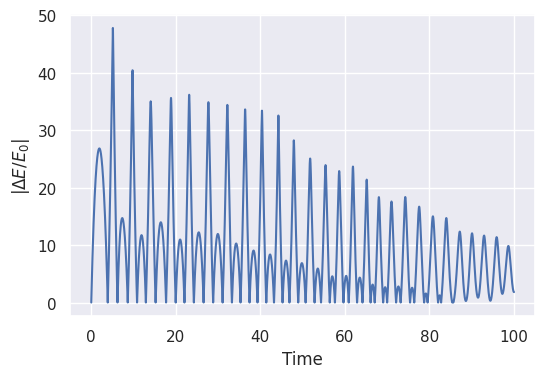

In [21]:
sma = (1 / (2 / np.linalg.norm(globular.positions[:,1,:], axis=1)
       - np.linalg.norm(globular.velocities[:,1,:], axis=1)**2 / 1))
nrg = 0.5 * np.linalg.norm(globular.velocities[:,1,:], axis=1)**2
nrg -= np.log(1+np.linalg.norm(globular.positions[:,1,:], axis=1) / sma) / np.linalg.norm(globular.positions[:,1,:], axis=1) * sma**3

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
ax.plot(globular.times, np.abs((nrg - nrg[0]) / nrg[0]))
# ax.set_yscale('log')
ax.set_xlabel('Time')
ax.set_ylabel(r'$|\Delta E/E_0|$')